# Introduction (Unfinished)

This notebook imports, verifies, and preprocesses the spam email data. It then models on this data using ***X, Y, Z ...***

# Libraries

In [12]:
import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D
from keras import initializers, regularizers, constraints, optimizers, layers

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [2]:
df_train = pd.read_csv('data/SMS_train.csv', encoding = 'latin1')
df_test = pd.read_csv('data/SMS_test.csv', encoding='latin1')

In [3]:
df_test.head()

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",Spam
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam
3,4,URGENT! Your Mobile number has been awarded wi...,Spam
4,5,Someone has contacted our dating service and e...,Spam


In [4]:
df_train.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


## Check Data Types

Checking that every entry is non-null and a string.

In [5]:
print(df_test.info(), "\n\n")
print(df_test.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
S. No.          125 non-null int64
Message_body    125 non-null object
Label           125 non-null object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB
None 


S. No.          0
Message_body    0
Label           0
dtype: int64


In [6]:
print(df_train.info(), "\n\n")
print(df_train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
S. No.          957 non-null int64
Message_body    957 non-null object
Label           957 non-null object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB
None 


S. No.          0
Message_body    0
Label           0
dtype: int64


Everything looks good to go.

## Investigate `"S. No."` Column

In [7]:
df_train['S. No.'] == df_train.index + 1

0      True
1      True
2      True
3      True
4      True
       ... 
952    True
953    True
954    True
955    True
956    True
Length: 957, dtype: bool

The column in question was just a manual index, starting at 1. Since Pandas gives us an index already, and it starts at `0`, we can drop `"S. No."`.

In [8]:
df_train.drop('S. No.', axis = 1, inplace = True)
df_test.drop('S. No.', axis = 1, inplace = True)

# Prepare Data For Modeling

## Prepare Email Message Content

Since the data is strings made of space-separated words, we need to first tokenize it. This gives us lists of integers corresponding to words-in-order. These lists are turned into arrays and padded, so that they are uniform in length.

In [9]:
# Example in
df_train['Message_body'][5]

'REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode'

In [13]:
# Instantiate and fit a Tokenizer on the training messages
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Message_body'])
X_train = tokenizer.texts_to_sequences(df_train['Message_body'])
X_train = np.array(X_train)
X_train = pad_sequences(X_train, maxlen=100)
with open('models/tokenizer_train.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

# Do same for testing messages
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_test['Message_body'])
X_test = tokenizer.texts_to_sequences(df_test['Message_body'])
X_test = np.array(X_test)
X_test = pad_sequences(X_test, maxlen=100)
with open('models/tokenizer_test.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# Example out
print(X_train[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1341   42  510    2   30   17  255  511   46   15  836    9  322
   18  109  632   69  116   17   41   99   31   13  368  254  228   37
    9 1342]


## Prepare Email Labels

Printed below is an example (read: reminder) that we just have two categories here. They will be converted to integers and then to categoricals, i.e. `"Non-Spam"` --> `0` --> `[1, 0]` and vice versa.

In [12]:
# Label example
df_train['Label'].head(6)

0    Non-Spam
1    Non-Spam
2    Non-Spam
3    Non-Spam
4        Spam
5        Spam
Name: Label, dtype: object

In [13]:
# Define int replacements
label_dict = {"Non-Spam": 0, "Spam": 1}

# Replace labels with int and pass to to_categorical()
y_train = keras.utils.to_categorical(
    [label_dict[label] for label in df_train['Label']])

# Repeat for test labels
y_test = keras.utils.to_categorical(
    [label_dict[label] for label in df_test['Label']])

In [14]:
# Finished example, matches above
print(y_train[0:6])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


We now have our `X_train`, `X_test`, `y_train`, and `y_test` ready and can begin modeling.

# Baseline Model

***Add reasoning for layer choices, explanation of `total_vocab` usage.***

In [31]:
all_words = df_train['Message_body'].str.split() 
total_vocab = set(word for text in all_words for word in text)
len(total_vocab)

4860

In [42]:
# Instantiate model
base_model = Sequential()

# Add model layers based on above rationale
base_model.add(Embedding(len(total_vocab), 100))
base_model.add(LSTM(8, return_sequences=True))
base_model.add(GlobalMaxPool1D())
base_model.add(Dense(25, activation='tanh'))
base_model.add(Dense(2, activation='softmax'))

# Compile model
base_model.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

# Fit model and store results
base_results = base_model.fit(X_train, y_train,
                              epochs=20, batch_size=30,
                              validation_split=0.2)

Train on 765 samples, validate on 192 samples
Epoch 1/20
765/765 [==============================] - 3s 3ms/step - loss: 0.6163 - acc: 0.7987 - val_loss: 0.4983 - val_acc: 0.8802
Epoch 2/20
765/765 [==============================] - 2s 2ms/step - loss: 0.3951 - acc: 0.8706 - val_loss: 0.3057 - val_acc: 0.8802
Epoch 3/20
765/765 [==============================] - 2s 2ms/step - loss: 0.2572 - acc: 0.8706 - val_loss: 0.2102 - val_acc: 0.8802
Epoch 4/20
765/765 [==============================] - 2s 3ms/step - loss: 0.1327 - acc: 0.9556 - val_loss: 0.1105 - val_acc: 0.9635
Epoch 5/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0466 - acc: 0.9948 - val_loss: 0.0689 - val_acc: 0.9792
Epoch 6/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0169 - acc: 1.0000 - val_loss: 0.0563 - val_acc: 0.9792
Epoch 7/20
765/765 [==============================] - 2s 3ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 0.9792
Epoch 8/20
765/765 [==========

In [43]:
# Helper function to visualize model performance over training
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

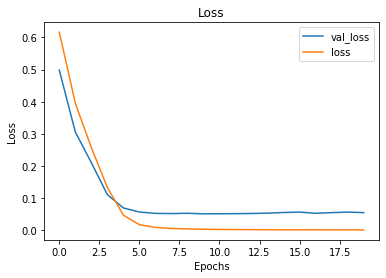

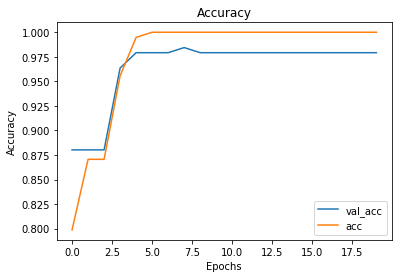

In [44]:
# Visualize baseline model performance
visualize_training_results(base_results)

I'm pleasantly surprised by the performance of this baseline architecture. The `acc` convergence to 100% accuracy suggests overfitting, and will be explored in later models. For now, this model will be saved and implemented in the educational game aspect of this project.

In [45]:
# Save the trained model
base_model.save('models/base_model')